In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import random

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(96, padding=4),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_set = torchvision.datasets.STL10(root="./data", split="train", download=True, transform=transform_train)
val_set = torchvision.datasets.STL10(root="./data", split="test", download=True, transform=transform_test)
test_set = torchvision.datasets.STL10(root="./data", split="test", download=True, transform=transform_test)

classes = train_set.classes
num_classes = len(classes)

print(f"Classes ({num_classes}): {classes}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Classes (10): ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


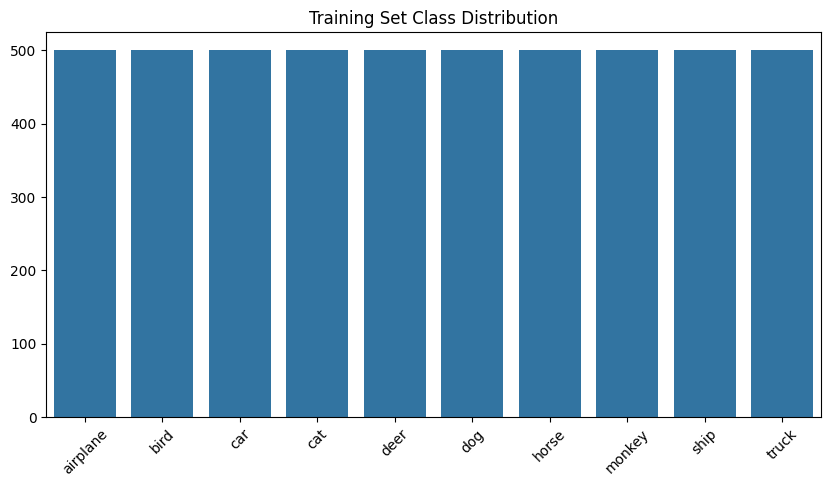

In [4]:
def plot_class_distribution(dataset, title):
    labels = [sample[1] for sample in dataset]
    label_counts = {label: labels.count(label) for label in set(labels)}
    plt.figure(figsize=(10, 5))
    sns.barplot(x=[classes[k] for k in label_counts.keys()], y=list(label_counts.values()))
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_set, "Training Set Class Distribution")


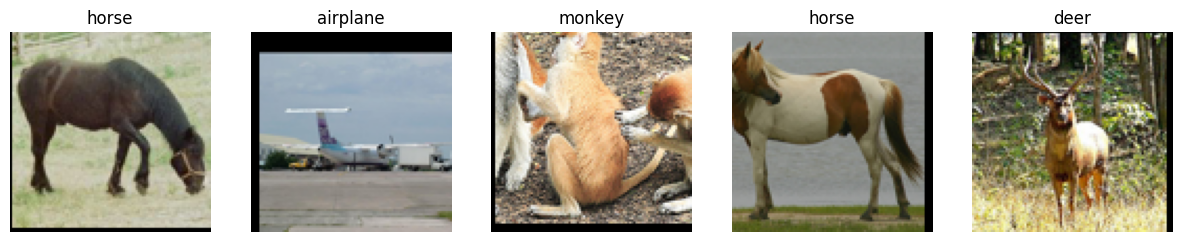

In [5]:
def show_images(dataset, num_samples=5):
    indices = random.sample(range(len(dataset)), num_samples)
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        axs[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axs[i].set_title(classes[label])
        axs[i].axis("off")
    plt.show()

show_images(train_set)


In [6]:
batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [7]:
class DeFixMatchImageModel(nn.Module):
    def __init__(self, num_classes):
        super(DeFixMatchImageModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 24 * 24, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = DeFixMatchImageModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "STL_DeFix.pt")

    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)


Epoch 1/20, Train Loss: 1.8702, Val Loss: 1.6575
Epoch 2/20, Train Loss: 1.5150, Val Loss: 1.4277
Epoch 3/20, Train Loss: 1.3681, Val Loss: 1.4264
Epoch 4/20, Train Loss: 1.2204, Val Loss: 1.2213
Epoch 5/20, Train Loss: 1.1120, Val Loss: 1.1283
Epoch 6/20, Train Loss: 1.0035, Val Loss: 1.1235
Epoch 7/20, Train Loss: 0.9346, Val Loss: 1.1233
Epoch 8/20, Train Loss: 0.8631, Val Loss: 1.0804
Epoch 9/20, Train Loss: 0.7786, Val Loss: 1.1693
Epoch 10/20, Train Loss: 0.7250, Val Loss: 1.0904
Epoch 11/20, Train Loss: 0.6588, Val Loss: 1.1090
Epoch 12/20, Train Loss: 0.5963, Val Loss: 1.1059
Epoch 13/20, Train Loss: 0.5402, Val Loss: 1.2791
Epoch 14/20, Train Loss: 0.4707, Val Loss: 1.2260
Epoch 15/20, Train Loss: 0.4420, Val Loss: 1.2520
Epoch 16/20, Train Loss: 0.3849, Val Loss: 1.2498
Epoch 17/20, Train Loss: 0.3186, Val Loss: 1.2855
Epoch 18/20, Train Loss: 0.2926, Val Loss: 1.3084
Epoch 19/20, Train Loss: 0.2978, Val Loss: 1.3609
Epoch 20/20, Train Loss: 0.2509, Val Loss: 1.4387


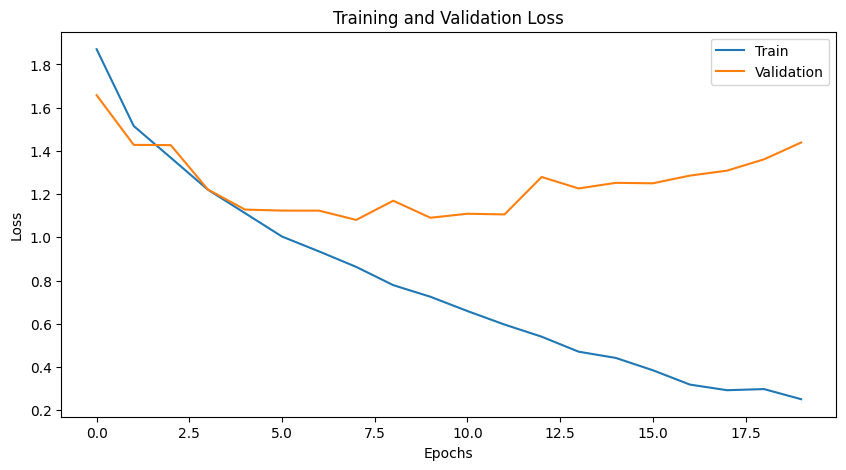

In [12]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
model.load_state_dict(torch.load("STL_DeFix.pt"))

def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

y_true, y_pred = evaluate_model(model, test_loader)
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

print(classification_report(y_true, y_pred, target_names=classes))


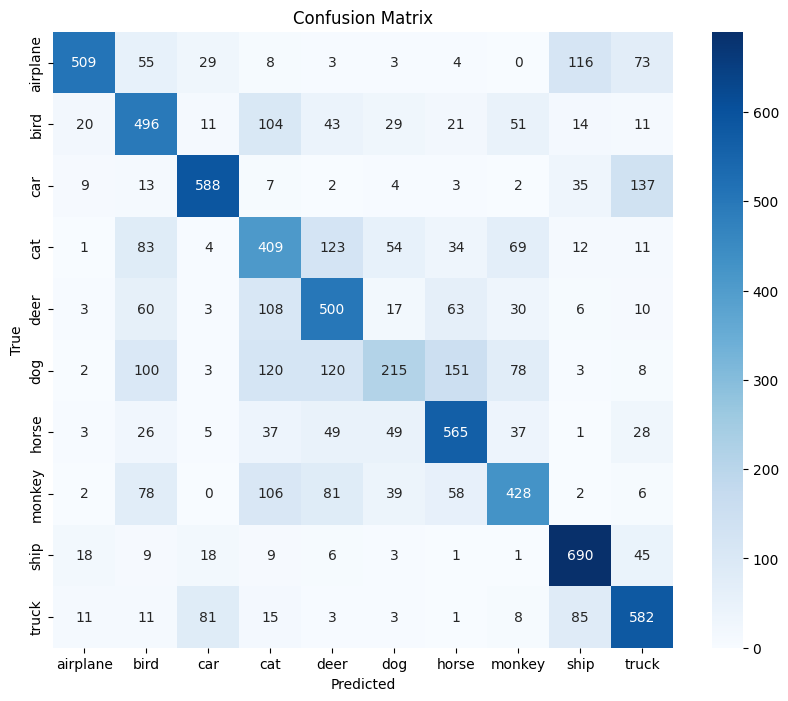

In [14]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
